In [1]:
from DatasetHandler.BiwiBrowser import *
import keras
import numpy as np
%matplotlib inline
#from keras import Model 
from keras.layers import *
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.sequence import TimeseriesGenerator

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
num_datasets = 24

In [35]:
num_outputs = 1

In [41]:
timesteps = 16
overlapping = True

In [42]:
#keras.backend.clear_session()
def getFinalModel(num_outputs = num_outputs):
    dense_layer_1 = 1#int((patch_size[0] * patch_size[1]) / 1)0010#00000
    dense_layer_2 = 8
    inp = BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = BIWI_Frame_Shape)
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2])))#batch_size = timesteps, 
    
    rnn.add(TimeDistributed(Flatten()))
    rnn.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2)) # , activation='relu', stateful=True
#    rnn.add(TimeDistributed(Dropout(0.2)))
    rnn.add(Dense(num_outputs))

    for layer in rnn.layers[:15]:
        layer.trainable = False
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [43]:
full_model = getFinalModel(num_outputs = num_outputs)

In [44]:
biwi = readBIWIDataset(subjectList = [s for s in range(1, num_datasets+1)])#, timesteps = timesteps, overlapping = overlapping

All frames and annotations from 24 datasets have been read by 2018-12-25 21:16:12.197884


In [45]:
c = 0
test_generators = []
test_labelSets = []
for inputMatrix, labels in biwi:
    data_gen = TimeseriesGenerator(inputMatrix, labels[:, :num_outputs], length=timesteps, batch_size=2)
    if c < num_datasets-1:
        full_model.fit_generator(data_gen, steps_per_epoch=len(data_gen), epochs=1, verbose=1) #
    else:
        test_generators.append(data_gen)
        test_labelSets.append(labels[:, :num_outputs])
    c += 1
    print('Batch %d done!' % c)

Epoch 1/1
241/241 [==============================] - 217s 902ms/step - loss: 0.5546 - mean_absolute_error: 0.6647
Batch 1 done!
Epoch 1/1
248/248 [==============================] - 227s 913ms/step - loss: 0.9996 - mean_absolute_error: 0.9325
Batch 2 done!
Epoch 1/1
357/357 [==============================] - 325s 909ms/step - loss: 0.9492 - mean_absolute_error: 0.9198
Batch 3 done!
Epoch 1/1
364/364 [==============================] - 331s 909ms/step - loss: 0.4991 - mean_absolute_error: 0.6198
Batch 4 done!
Epoch 1/1
465/465 [==============================] - 423s 910ms/step - loss: 0.5127 - mean_absolute_error: 0.6470
Batch 5 done!
Epoch 1/1
263/263 [==============================] - 239s 909ms/step - loss: 0.2729 - mean_absolute_error: 0.4513
Batch 6 done!
Epoch 1/1
365/365 [==============================] - 331s 908ms/step - loss: 0.1776 - mean_absolute_error: 0.3407
Batch 7 done!
Epoch 1/1
378/378 [==============================] - 344s 909ms/step - loss: 1.0802 - mean_absolute_erro

In [46]:
test_gen = test_generators[0]
test_labels = test_labelSets[0]

In [47]:
predictions = full_model.predict_generator(test_gen)

In [48]:
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

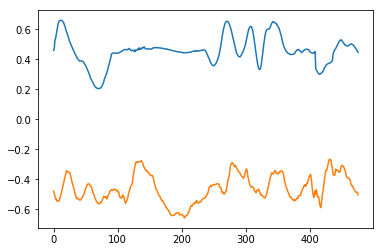

In [49]:
plt.plot(output1)